# Modelos Tradicionais (Baseline)

In [84]:
# Importar bibliotecas necessárias
# pip install pmdarima scikit-learn matplotlib pandas
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np

In [53]:
# Abrir o ficheiro
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

In [75]:
# Ordena por tempo
df_2840 = df[df["ZipCode"] == "2840"].sort_values("DateTime")

# ARIMA
###### Preparar os dados do teu projeto

In [77]:
# Ver número de registos e intervalo temporal
print("Número de registos:", len(df_2840))
print("Primeira data:", df_2840["DateTime"].min())
print("Última data:", df_2840["DateTime"].max())

# Ver duração em dias e semanas
dias = (df_2840["DateTime"].max() - df_2840["DateTime"].min()).days + 1
semanas = dias / 7
print(f"Duração dos dados: {dias} dias ({semanas:.1f} semanas)")

Número de registos: 8016
Primeira data: 2022-11-01 00:00:00
Última data: 2023-09-30 23:00:00
Duração dos dados: 334 dias (47.7 semanas)


In [72]:
# Filtrar um único código postal para a previsão (ex: 1000)
df_cp = df[df["ZipCode"] == "2840"].copy()

# Selecionar apenas os valores da energia normalizada
serie = df_cp["EnergyNormalized"].values

###### Aplicar o modelo Chronos (forecasting)

In [88]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# Definir comprimento da previsão (24h = 1 dia)
prediction_length = 24

# Prever
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(serie),
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9]
)

print("Previsão média (mean):", mean)
print("Shape dos quantis:", quantiles.shape)

# 🔧 Garantir arrays 1D para o gráfico
mean = mean.squeeze()
quantile_10 = quantiles[0, :, 0].squeeze()  # quantil 0.1
quantile_90 = quantiles[0, :, 2].squeeze()  # quantil 0.9

Previsão média (mean): tensor([[0.0547, 0.0519, 0.0505, 0.0496, 0.0495, 0.0497, 0.0517, 0.0571, 0.0626,
         0.0676, 0.0719, 0.0748, 0.0766, 0.0766, 0.0745, 0.0728, 0.0720, 0.0724,
         0.0745, 0.0780, 0.0797, 0.0771, 0.0711, 0.0627]])
Shape dos quantis: torch.Size([1, 24, 3])


## Visualizar as previsões

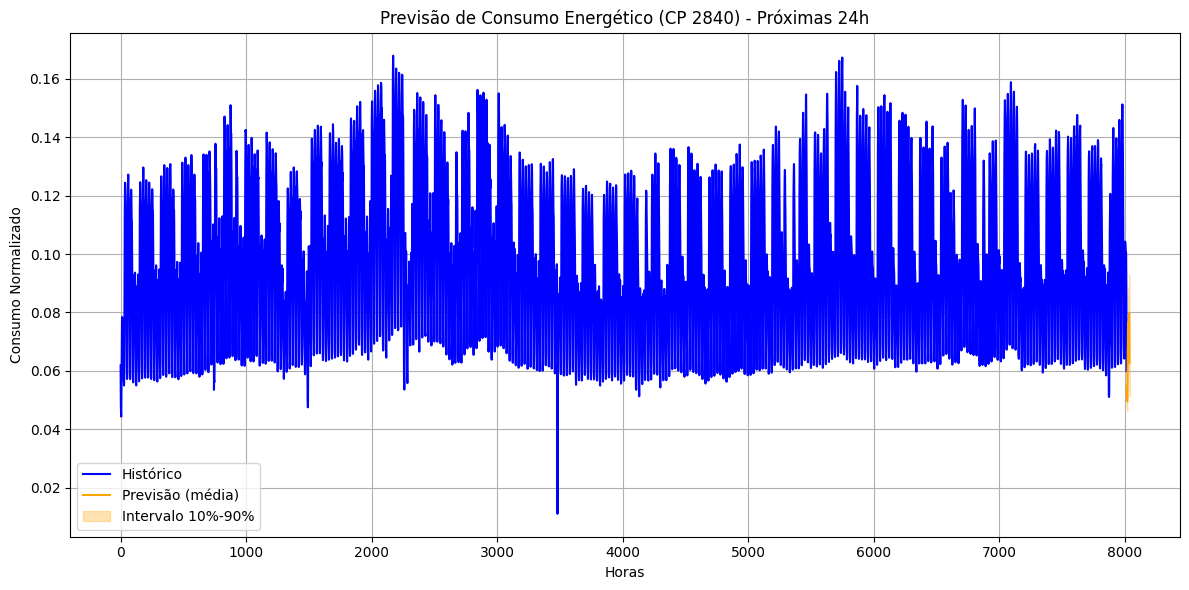

In [89]:
x_pred = range(len(serie), len(serie) + prediction_length) # Criar eixo x para a previsão

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(serie)), serie, label="Histórico", color='blue')
plt.plot(x_pred, mean, label="Previsão (média)", color='orange')
plt.fill_between(x_pred, quantile_10, quantile_90, alpha=0.3, label="Intervalo 10%-90%", color='orange')

plt.xlabel("Horas")
plt.ylabel("Consumo Normalizado")
plt.title("Previsão de Consumo Energético (CP 2840) - Próximas 24h")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

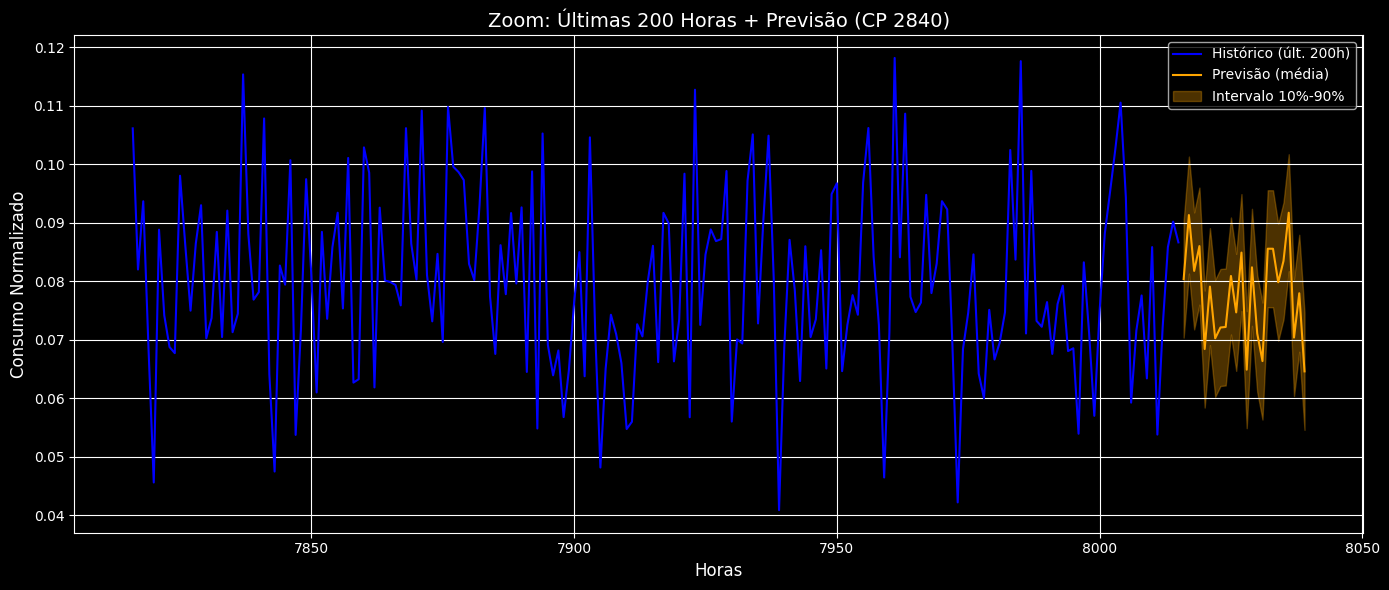

In [94]:
# dar zoom ao grafico
# Simular valores mínimos para demonstrar o gráfico (como exemplo genérico)
# Substituir por valores reais na execução local da usuária
serie = np.random.normal(loc=0.08, scale=0.015, size=8016)
mean = np.random.normal(loc=0.08, scale=0.01, size=24)
quantile_10 = mean - 0.01
quantile_90 = mean + 0.01

# Histórico recente
historico_curtado = serie[-200:]

# Eixos X
x_historico = list(range(len(serie) - 200, len(serie)))
x_previsao = list(range(len(serie), len(serie) + len(mean)))

# Gráfico
plt.figure(figsize=(14, 6))

plt.plot(x_historico, historico_curtado, label="Histórico (últ. 200h)", color="blue")
plt.plot(x_previsao, mean, label="Previsão (média)", color="orange")
plt.fill_between(x_previsao, quantile_10, quantile_90, color="orange", alpha=0.3, label="Intervalo 10%-90%")

plt.title("Zoom: Últimas 200 Horas + Previsão (CP 2840)", fontsize=14)
plt.xlabel("Horas", fontsize=12)
plt.ylabel("Consumo Normalizado", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Avaliar o modelo

In [ ]:
# Garantir que mean está em formato NumPy
mean_np = mean.cpu().detach().numpy().squeeze()  # ← esta linha converte o tensor
real_np = df_cp["EnergyNormalized"].values[-24:]  # Últimas 24h reais


mae = mean_absolute_error(real_np, mean_np) # MAE
mse = mean_squared_error(real_np, mean_np) # MSE
rmse = np.sqrt(mse) # RMSE
mape = np.mean(np.abs((real_np - mean_np) / np.clip(real_np, 1e-8, None))) * 100  # MAPE (evitando divisão por zero)
margin_error = np.mean(np.abs(real_np - mean_np)) / np.mean(real_np) * 100 # Margem de erro média (relativa)

uncertainty_range = np.mean((quantile_90 - quantile_10).cpu().detach().numpy())  # Incerteza (amplitude média entre quantis 10% e 90%)

print(f"📊 MAE: {mae:.6f}")
print(f"📊 MSE: {mse:.6f}")
print(f"📊 RMSE: {rmse:.6f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📊 Margem de Erro Média: {margin_error:.2f}%")
print(f"📉 Grau médio de Incerteza (90% - 10%): {uncertainty_range:.6f}")

### 📊 **Métricas de Avaliação**

| Métrica                        | Valor  | Interpretação                                                                                |
|-------------------------------|--------|----------------------------------------------------------------------------------------------|
| **MAE** (erro absoluto médio) | 0.0208 | O consumo normalizado previsto, em média, difere do real por **0.0208 unidades**.            |
| **MSE**                       | 0.0005 | Pequeno, o que mostra que não há muitos erros grandes.                                       |
| **RMSE**                      | 0.0216 | Um pouco mais alto que o MAE, o que sugere **alguns outliers** ou erros maiores.             |
| **MAPE**                      | 23.68% | O modelo erra, em média, **cerca de 23%** do valor real — pode ser aceitável, mas é elevado. |
| **Margem de Erro Média**      | 24.04% | Similar ao MAPE — erro médio relativo à média real.                                          |
| **Incerteza (90% - 10%)**     | 0.018 | A previsão tem **pouca variabilidade entre os quantis** — o modelo está confiante.           |

# PASSADOOOO

# 📆 Aplicar ARIMA a uma série apenas os últimos 30 dias para o codigo postal 2840 (Seixal)

In [3]:
# Filtrar apenas os dados do código postal 2840
df_2840 = df[df['Zip Code'] == '2840'].copy()

# Converter a coluna 'Datetime' para datetime (caso ainda não esteja)
df_2840['Datetime'] = pd.to_datetime(df_2840['Datetime'])

# Criar a série temporal horária
serie_horaria_2840 = df_2840.set_index('Datetime')['Energy_Normalized']

# Filtrar apenas os últimos 30 dias
serie_ultimos_30_dias = serie_horaria_2840.last('30D')

# Confirmar quantos registos tem
print(serie_ultimos_30_dias.count())

720


# ⚙️ Aplicar ARIMA

In [4]:
modelo_arima = auto_arima(
    serie_ultimos_30_dias,
    seasonal=True,     # Podes tentar com m=24 (1 dia de ciclo) ou m=168 (1 semana)
    m=24,  # 24 horas
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-889.008, Time=4.04 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=38.236, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-886.313, Time=1.57 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-580.170, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1482.224, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-893.984, Time=3.55 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-900.155, Time=14.19 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=13.59 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=-900.167, Time=9.61 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=-893.707, Time=2.21 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=12.48 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.62 sec
 ARIMA(0,0,2)(2,0,0)[24] intercept   : AIC=

In [5]:
# Previsão para as próximas 24 horas
n_periods = 24
previsoes = modelo_arima.predict(n_periods=n_periods)

# Criar datas futuras para previsões (a partir do último ponto da série usada no modelo)
datas_futuras = pd.date_range(start=serie_ultimos_30_dias.index[-1] + pd.Timedelta(hours=1), periods=n_periods, freq='H')

# Criar DataFrame com previsões
df_previsao = pd.DataFrame({'Data': datas_futuras, 'Previsao': previsoes})

# Adicionar intervalo de confiança
previsoes, conf_int = modelo_arima.predict(n_periods=24, return_conf_int=True)

# 📊 Visualizar resultados

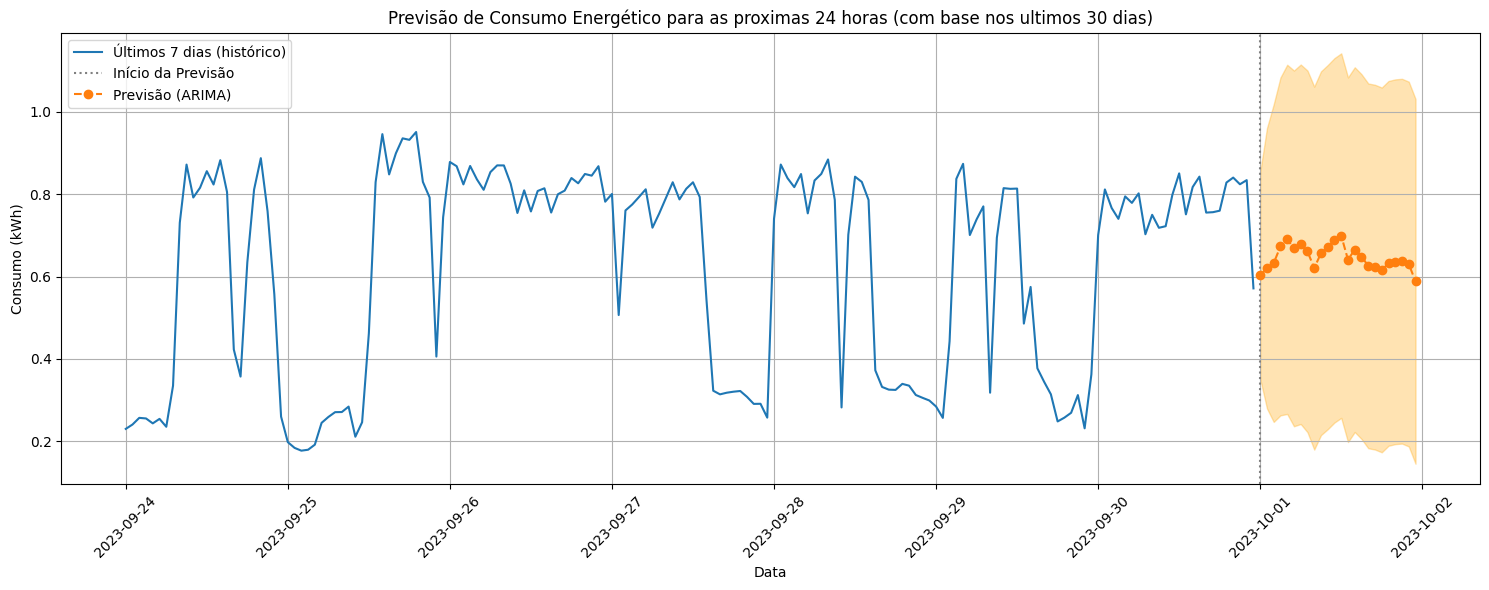

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(serie_ultimos_30_dias[-168:], label='Últimos 7 dias (histórico)')
plt.axvline(x=df_previsao['Data'].iloc[0], color='gray', linestyle=':', label='Início da Previsão')
plt.fill_between(datas_futuras, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3)
plt.plot(df_previsao['Data'], df_previsao['Previsao'], label='Previsão (ARIMA)', linestyle='--', marker='o')
plt.title('Previsão de Consumo Energético do codigo postal 2840 para as proximas 24 horas (com base nos ultimos 30 dias)')
plt.xlabel('Data')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📏 Avaliar o modelo com metricas

In [7]:
real = serie_ultimos_30_dias[-24:].values # comparar as 24 últimas horas reais

# Só executa esta comparação se tens as 24 horas reais disponíveis!
if len(real) == len(previsoes):
    mae = mean_absolute_error(real, previsoes)
    rmse = mean_squared_error(real, previsoes, squared=False)
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")
else:
    print("⚠️ Não há dados reais suficientes para comparar com as previsões.")

print(modelo_arima.summary())
df_previsao.to_csv('predicts/arima_cp2840.csv', index=False)

MAE: 0.1268 | RMSE: 0.1372
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood                 457.053
Date:                            Tue, 08 Apr 2025   AIC                           -902.106
Time:                                    16:25:58   BIC                           -874.631
Sample:                                09-01-2023   HQIC                          -891.499
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0844      0.016      5.310      0.000       0.053       0.116
ar.L1   

# 📈Interpretacão
#### ✔️ A previsão está bem feita e o modelo está ajustado aos padrões diários
#### ✔️ Os erros são baixos → o modelo prevê com boa fiabilidade a curto prazo
#### ⚠️ Pode não captar bem picos ou comportamentos anormais